<a href="https://colab.research.google.com/github/gautamjoshi1984/Toxic-Comment-Classification-LJMU/blob/main/BERT_MUTLIPLE_CNN_CONCATENATION_2023(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries used later that will need installation and some extra time

In [ ]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 65.0 MB/s eta 0:00:00


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

## Installing Datasets

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from datasets import load_dataset

dataset = load_dataset("sst2")

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset sst2 downloaded and prepared to /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

## Class for the Model

In [ ]:
from torch import nn
import torch.nn.functional as F
import torch
from torch.nn import CrossEntropyLoss
import pandas as pd
import numpy as np

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from transformers import AutoTokenizer
from torch import nn
import torch.nn.functional as F
import unicodedata
import numpy as np
import time
import datetime
import torch
import gc

In [ ]:
class CNNBert(nn.Module):

    def __init__(self, embed_size,bert_model,num_classes):
        super(CNNBert, self).__init__()
        filter_sizes_convs_1 = [3,5]
        filter_sizes_convs_2 = [2,4]
        filter_sizes_convs_3 = [2,3]
        num_filters = 100
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes_convs_1])
        self.convs2 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes_convs_2])
        self.convs3 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes_convs_3])
        self.dropout = nn.Dropout(0.1)
        linear_layer_size = (len(filter_sizes_convs_1)+len(filter_sizes_convs_2)+len(filter_sizes_convs_3))*num_filters
        self.fc1 = nn.Linear(linear_layer_size, linear_layer_size//2)
        self.fc2 = nn.Linear(linear_layer_size//2,num_classes)
        self.bert_model = bert_model

    def forward(self, x, input_masks, token_type_ids):
        x = x.squeeze(1)
        input_masks = input_masks.squeeze(1)
        token_type_ids = token_type_ids.squeeze(1)
        x = self.bert_model(x, attention_mask=input_masks, token_type_ids=token_type_ids,output_hidden_states=True)[2][-3:]
        x1 = x[0].unsqueeze(0).permute(1, 0, 2, 3)
        x2 = x[1].unsqueeze(0).permute(1, 0, 2, 3)
        x3 = x[2].unsqueeze(0).permute(1, 0, 2, 3)
        x1 = [F.gelu(conv(x1)).squeeze(3) for conv in self.convs1]
        x2 = [F.gelu(conv(x2)).squeeze(3) for conv in self.convs2]
        x3 = [F.gelu(conv(x3)).squeeze(3) for conv in self.convs3]
        x1_pooled = torch.cat([F.max_pool1d(i, i.size(2)).squeeze(2) for i in x1],dim=1)
        x2_pooled = torch.cat([F.max_pool1d(i, i.size(2)).squeeze(2) for i in x2],dim=1)
        x3_pooled = torch.cat([F.max_pool1d(i, i.size(2)).squeeze(2) for i in x3],dim=1)
        x_concat = torch.cat([x1_pooled,x2_pooled,x3_pooled],1)
        # print("After Pooling")
        # print(len(x))
        # print(x[0].data.shape)
        # print(x[1].data.shape)
        # print(x[2].data.shape)
        # print("Concatenation")
        # print(x.data.shape)
        x_concat = self.dropout(x_concat)
        x_concat = self.fc1(x_concat)
        logits = self.fc2(F.gelu(x_concat))
        return logits

## Tokenizing Sentences from Dataset Using Bert-Tokenizer

In [ ]:
from transformers import AutoTokenizer,DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def tokenize(batch):
  return tokenizer(batch["sentence"], truncation=True,padding='max_length',max_length=66,return_tensors='pt')
sst2_dataset_encoded = dataset.map(tokenize, batched=False)

  0%|          | 0/67349 [00:00<?, ?ex/s]

  0%|          | 0/872 [00:00<?, ?ex/s]

  0%|          | 0/1821 [00:00<?, ?ex/s]

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

## Train and Validation Dataset

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# def collate(data):
#   print(data)
def data_loader(dataset,batch_size):
  data_train = dataset['train']
  train_data = TensorDataset(torch.tensor(data_train['input_ids']),torch.tensor(data_train['attention_mask']),torch.tensor(data_train['token_type_ids']),torch.tensor(data_train['label']))
  train_sampler = RandomSampler(train_data)
  # dataLoader for train set
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
  # sampler for sampling the data during training
  data_val = dataset['validation']
  val_data = TensorDataset(torch.tensor(data_val['input_ids']),torch.tensor(data_val['attention_mask']),torch.tensor(data_val['token_type_ids']),torch.tensor(data_val['label']))
  val_sampler = SequentialSampler(val_data)
  # dataLoader for validation set
  val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
  num_classes = len(pd.Series(dataset['train']['label']).unique())
  return train_dataloader,val_dataloader,num_classes

## Train Code Function



In [ ]:
constraint = 3.0
def train(train_dataloader,loss_fn,batch_size,optimizer):
    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds = []

    # iterate over batches
    total = len(train_dataloader)
    for i, batch in enumerate(train_dataloader):

        step = i+1
        percent = "{0:.10f}".format(100 * (step / float(total)))
        lossp = "{0:.10f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>'  *(filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')

        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        input_id, input_mask, token_type_ids, labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch

        preds = model(input_id, input_mask,token_type_ids)

        # compute the loss between actual and predicted values
        loss = loss_fn(preds, labels)

        # add on to the total loss
        total_loss += float(loss.item())

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        #preds = preds.detach().cpu().numpy()

        # append the model predictions
        #total_preds.append(preds)
        total_preds.append(preds.detach().cpu().numpy())

    gc.collect()
    torch.cuda.empty_cache()

    # compute the training loss of the epoch
    avg_loss = total_loss / (len(train_dataloader)*batch_size)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    # returns the loss and predictions
    return avg_loss, total_preds





## Evaluate Code Function

In [ ]:
# function for evaluating the model
def evaluate(val_dataloader,loss_fn,batch_size):
    print("\n\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []
    total_labels = []
    # iterate over batches
    total = len(val_dataloader)
    for i, batch in enumerate(val_dataloader):

        step = i+1
        percent = "{0:.10f}".format(100 * (step / float(total)))
        lossp = "{0:.10f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>' * (filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        input_id, input_mask, token_type_ids,labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(input_id, input_mask,token_type_ids)

            # compute the validation loss between actual and predicted values
            loss = loss_fn(preds, labels)

            total_loss += float(loss.item())
            #preds = preds.detach().cpu().numpy()

            #total_preds.append(preds)
            total_preds+=[np.argmax(p) for p in preds.detach().cpu().numpy()]
            total_labels+=labels.detach().cpu()

    gc.collect()
    torch.cuda.empty_cache()

    # compute the validation loss of the epoch
    avg_loss = total_loss / (len(val_dataloader)*batch_size)
    print(total_labels)
    print(total_preds)
    # reshape the predictions in form of (number of samples, no. of classes)
    print(classification_report(total_labels, total_preds, digits=4))
    val_score = f1_score(total_labels, total_preds,average='weighted')
    print(val_score)
    print("Accuracy Score",accuracy_score(total_labels, total_preds))
    return avg_loss, total_preds

## Training Loop Using Epochs in Gradient Descent

### In this I have pruned all the self-attention Heads of BERT Base model from layer 0. There is no scheduler. I have used the learning rate of 3e-5 and weight decay of 0.01. Batch Size is Kept as 32. Many CNN layers are used which can be seen in diagram constructed below.

In [ ]:

batch_size=32
# sst2_dataset_encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "token_type_ids","labels"])
train_dataloader,val_dataloader,num_classes = data_loader(sst2_dataset_encoded,batch_size)
from transformers import BertModel
bert_model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
bert_model.config.prune_heads={0: [0,1,2,3,4,5,6,7,8,9,10,11]}
model = CNNBert(768,bert_model,num_classes)
# model = torch.load('/content/drive/MyDrive/BERT_CNN_SST2_3_Epoch_lr_Scheduler.pth')
model = model.to(device)

# optimizer from hugging face transformers
from transformers import AdamW,get_linear_schedule_with_warmup
epochs = 5
current = 1
total_steps = len(train_dataloader) * epochs
# define the optimizer
optimizer = AdamW(model.parameters(), lr=3e-5,weight_decay=0.01)
# scheduler = get_linear_schedule_with_warmup(optimizer,
#                                         num_warmup_steps = 10,
#                                         num_training_steps = total_steps)
loss_fn = nn.CrossEntropyLoss()
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
#train_losses = []
#valid_losses = []

#if os.path.isfile("/content/drive/MyDrive/saved_weights.pth") == False:
#if os.path.isfile("saved_weights.pth") == False:
    # number of training epochs

# for each epoch
while current <= epochs:

    print(f'\nEpoch {current} / {epochs}:')

    # train model
    train_loss, _ = train(train_dataloader,loss_fn,batch_size,optimizer)

    # evaluate model
    valid_loss, _ = evaluate(val_dataloader,loss_fn,batch_size)
    print(f'\n\nTraining Loss: {train_loss:.12f}')
    print(f'Validation Loss: {valid_loss:.12f}')
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'saved_weights.pth')

    # append training and validation loss
    #train_losses.append(train_loss)
    #valid_losses.append(valid_loss)



    current = current + 1
#else:
    #print("Got weights!")
    # load weights of best model
    #model.load_state_dict(torch.load("saved_weights.pth"))
    #model.load_state_dict(torch.load("/content/drive/MyDrive/saved_weights.pth"), strict=False)

# get predictions for test data
gc.collect()
torch.cuda.empty_cache()

# with torch.no_grad():
#     preds = model(test_seq.to(device), test_mask.to(device))
#     #preds = model(test_seq, test_mask)
#     preds = preds.detach().cpu().numpy()


# print("Performance:")
# # model's performance
# preds = np.argmax(preds, axis=1)
# print('Classification Report')
# print(classification_report(test_y, preds))

# print("Accuracy: " + str(accuracy_score(test_y, preds)))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a


Epoch 1 / 5:
Batch 2105/2105 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0000000000% complete, loss=0.0061992207, accuracy=0

Evaluating...
Batch 28/28 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0000000000% complete, loss=0.0062737684, accuracy=0[tensor(1), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(0), tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(0), tensor(1), tensor(0), tensor(0), tensor(0), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(0)

KeyboardInterrupt: ignored

## Visualizing the Model

In [ ]:
! pip install -q torchview
! pip install -q -U graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 2.6 MB/s eta 0:00:00


In [ ]:
from torchview import draw_graph
import torchtext
from torch import nn
import torch
import graphviz

# when running on VSCode run the below command
# svg format on vscode does not give desired result
graphviz.set_jupyter_format('png')

'svg'

In [ ]:
from transformers import BertModel
bert_model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
model = CNNBert(768,bert_model,2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_id = sst2_dataset_encoded['train'][0:32]['input_ids']
input_mask = sst2_dataset_encoded['train'][0:32]['attention_mask']
token_type_ids = sst2_dataset_encoded['train'][0:32]['token_type_ids']
#batch size is 32

In [ ]:
model_graph3 = draw_graph(
    model, (torch.tensor(input_id),torch.tensor(input_mask),torch.tensor(token_type_ids)),
    graph_name='BERT_CNN',
)

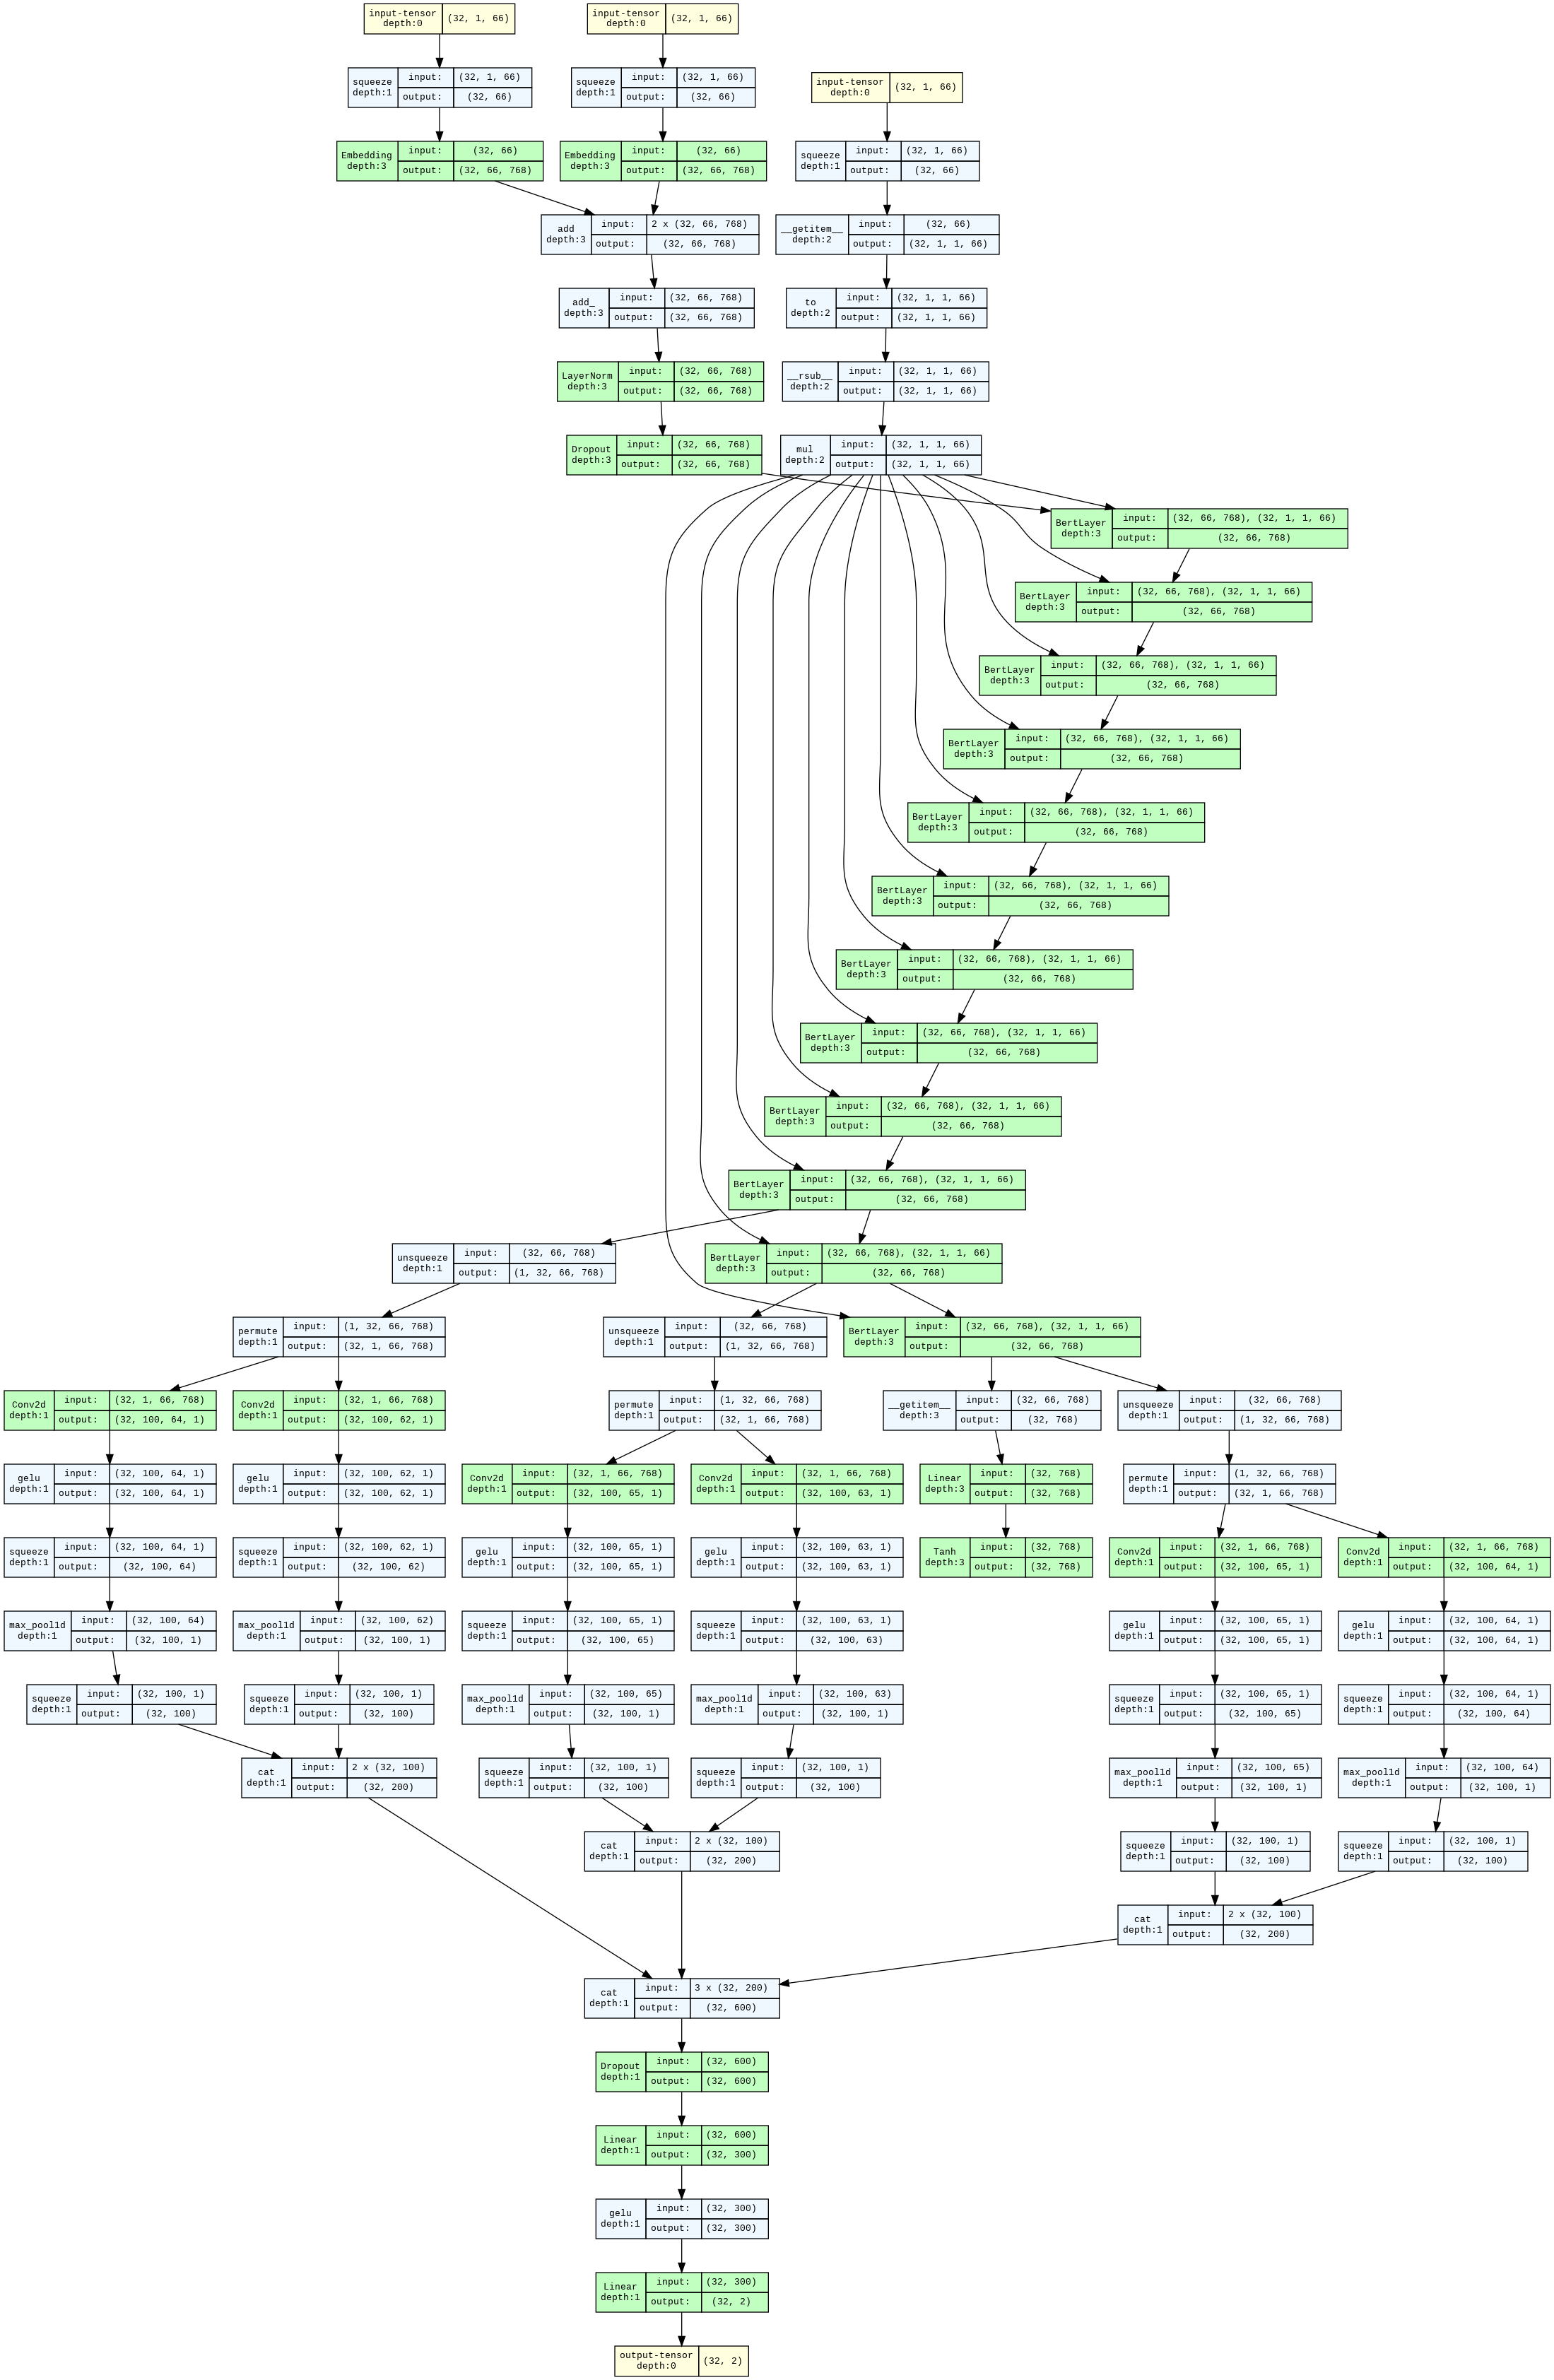

In [ ]:
model_graph3.visual_graph